## Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading libraies

In [3]:
import numpy as np
import pandas as pd
import scipy.io
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras import Model,datasets
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten,
    Dropout, Reshape
)
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time


In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')
lung_cancer.head()

,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,11130,7789,158586,79364,440590,79699,7791,23140,26009,Subtype
0,NaN,-0.0353,-0.0307,-2.8954,1.7786,NaN,2.3132,0.2043,NaN,NaN,...,4.0661,-1.1426,-1.1659,-0.9328,-0.7040,0.3973,-2.6391,-1.5597,0.3740,LUAD
1,NaN,-0.4349,0.1330,-0.1829,2.1286,NaN,0.8965,1.0067,NaN,NaN,...,2.7074,0.6910,1.1827,0.0517,5.0105,-1.5295,-3.2362,-0.8057,1.4777,LUAD
2,NaN,-0.4268,-1.0444,-2.9011,2.9987,NaN,-0.7793,-2.1634,NaN,NaN,...,5.6950,0.5476,-0.1674,-1.5433,5.5920,-4.5388,-0.5748,-0.7265,-0.0895,LUAD
3,NaN,0.1178,-0.6817,-0.5842,1.5703,NaN,1.7180,-0.8709,NaN,NaN,...,4.9330,-1.0764,-0.4027,-0.9956,7.5633,-0.6799,0.1212,-0.7296,1.2411,LUAD
4,NaN,-1.3313,-1.8518,-1.1841,0.0756,NaN,1.9364,-0.5877,NaN,NaN,...,1.2673,1.7380,1.7759,0.5915,3.0505,-1.5952,-2.1206,0.3884,1.7606,LUAD


In [ ]:
lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

lung_cancer_no_na.shape

(966, 19219)

In [ ]:
X = X.to_numpy()
y = y.tolist()

## SVM

In [ ]:
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit and transform the 'Class' column
y = le.fit_transform(y)

# Keep track of corresponding subtype names
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
label_mapping

{'LUAD': 0, 'LUSC': 1}

In [ ]:
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(y)
print(class_counts)

# Calculate the total number of instances
total_instances = len(y)

# Calculate and print the percentage of each class
class_percentages = {cls: count / total_instances * 100 for cls, count in class_counts.items()}
for cls, percentage in class_percentages.items():
    print(f"Class '{cls}': {percentage:.1f}%")

Counter({0: 502, 1: 464})
Class '0': 52.0%
Class '1': 48.0%


### Cross Validation

In [ ]:
random_state = 38
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []

for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])


    model = OneVsRestClassifier(svm.SVC(#kernel='rbf',
                                        #C = 3,
                                        probability=True,
                                        random_state=random_state
                                        ))
    clt = model.fit(X_train, y_train)
    y_pred = clt.predict(X_val)

    # Calculate metrics
    print(f"Accureacy: {accuracy_score(y_val, y_pred)}")
    accuracies.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred, average='weighted', zero_division=0))
    precisions.append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
    confusion_matrices.append(confusion_matrix(y_val, y_pred))
    kappas.append(cohen_kappa_score(y_val, y_pred))
    hamming_distances.append(hamming_loss(y_val, y_pred))

    fold_no = fold_no + 1

    # Break the loop after the first iteration to test the code
    #break

Training for fold1...
Accureacy: 1.0
Training for fold2...
Accureacy: 0.9878048780487805
Training for fold3...
Accureacy: 1.0
Training for fold4...
Accureacy: 1.0
Training for fold5...
Accureacy: 1.0
Training for fold6...
Accureacy: 1.0
Training for fold7...
Accureacy: 0.9878048780487805
Training for fold8...
Accureacy: 0.975609756097561
Training for fold9...
Accureacy: 0.9878048780487805
Training for fold10...
Accureacy: 0.9390243902439024


In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_kappa = np.mean(kappas)
avg_hamming_distance = np.mean(hamming_distances)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.9914634146341463
Average F1 Score: 0.9914668973834149
Average Precision: 0.9917876500193573
Average Recall: 0.9914634146341463
Average Cohen Kappa: 0.9825826635195792
Average Hamming Distance: 0.008536585365853657


### Test Accuracy

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [ ]:
start_time = time.time()
random_state = 38
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X_train, y_train)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])

X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])


model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                    C = 3,
                                    probability=True,
                                    random_state=random_state
                                    ))
clt = model.fit(X_train, y_train)
y_pred = clt.predict(X_test)

# Calculate metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(elapsed_time_1)

Accuracy: 0.9948453608247423
22.044954538345337


In [ ]:
# Calculate metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Precision: {precsion_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy: 0.9948453608247423
F1 Score: 0.994844125523116
Precision: 0.994844125523116


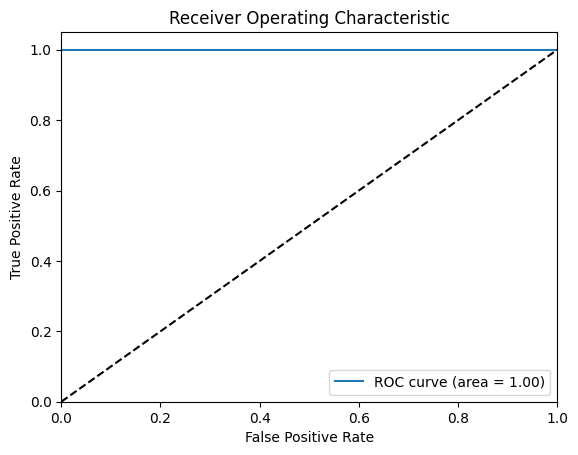

In [ ]:
# Predict probability scores for the positive class
y_prob = clt.predict_proba(X_test)[:, 1]  # Assuming the second column is for the positive class

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature selection

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

random_state = 38
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)

# X_train, y_train = smote.fit_resample(X_train, y_train)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)

# Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

clt = OneVsRestClassifier(SVC(kernel='linear', C=3, random_state=random_state))
clt.fit(X, y)

OneVsRestClassifier(estimator=SVC(C=3, kernel='linear', random_state=38))

In [ ]:
import numpy as np

# Extract feature coefficients from each classifier
coefficients = np.array([estimator.coef_[0] for estimator in clt.estimators_])

# Aggregate coefficients - you can use different methods like mean, absolute mean, max, etc.
# Here we use the absolute mean to consider overall importance irrespective of the class
feature_importance = np.mean(np.abs(coefficients), axis=0)

# Get the indices of the top 20 features
top_20_indices = np.argsort(feature_importance)[-20:]

# Retrieve the names of the top 20 features
top_20_features = retained_features[top_20_indices]
print(top_20_features)

['219793' '731779' '56918' '341799' '677842' '150921' '353141' '7455'
 '646603' '85285' '440956' '378807' '3018' '677835' '402117' '114026'
 '390999' '26689' '646625' '390439']


In [ ]:
# random_state = 38
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=4, random_state=1207)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
# retained_features = np.array(genes)[var_filter]

# # Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

# clt = OneVsRestClassifier(SVC(kernel='linear', C=3, random_state=random_state))
# clt.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=3, kernel='linear', random_state=38))

In [ ]:
# gene_names = retained_features
# top_genes_per_subtype = {}
# output_str_per_subtype = {}

# for i, estimator in enumerate(clt.estimators_):
#     # Extract coefficients for the current estimator
#     coefficients = estimator.coef_[0]

#     # Create a DataFrame of genes and their coefficients
#     gene_importance = pd.DataFrame({'Gene': gene_names, 'Coefficient': coefficients})

#     # Sort by the absolute values of coefficients to get top genes
#     gene_importance_sorted = gene_importance.reindex(gene_importance.Coefficient.abs().sort_values(ascending=False).index)

#     # Calculate the number of top genes (10%)
#     top_n = int(len(gene_importance_sorted) * 0.1)

#     # Save the top 10% genes for this subtype
#     top_genes = gene_importance_sorted.head(top_n)
#     top_genes_per_subtype[f'Subtype_{i}'] = top_genes

#     # Prepare output string for top genes (up to first 9 genes)
#     top_genes_str = ", ".join(top_genes['Gene'].astype(str).head(9))
#     output_str_per_subtype[f'Subtype_{i}'] = f"{top_genes.shape[0]} features selected for Subtype_{i}: {top_genes_str}..."

# # Print the formatted output
# for subtype, output_str in output_str_per_subtype.items():
#     print(output_str)

1345 features selected for Subtype_0: 150921, 390439, 646625, 84672, 10816, 114026, 83863, 26689, 252948...


In [ ]:
# # Initialize a binary matrix with subtypes as both rows and columns
# binary_matrix = pd.DataFrame(0, index=top_genes_per_subtype.keys(), columns=top_genes_per_subtype.keys())

# # Fill in the binary matrix with the count of shared top genes
# for subtype1, data1 in top_genes_per_subtype.items():
#     for subtype2, data2 in top_genes_per_subtype.items():
#         if subtype1 != subtype2:
#             # Count the number of shared genes between subtype1 and subtype2
#             shared_genes = len(set(data1['Gene']).intersection(set(data2['Gene'])))
#             binary_matrix.loc[subtype1, subtype2] = shared_genes
#         else:
#             # Diagonal elements (same subtype comparison)
#             binary_matrix.loc[subtype1, subtype2] = len(data1)

# # Display the shared genes matrix
# shared_genes_matrix = binary_matrix
# shared_genes_matrix


,Subtype_0
Subtype_0,1345


### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()

  print(f"The split ratio is: {ratio}:")

  random_state = 38
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=random_state, stratify=y)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])

  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])


  model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                      C = 3,
                                      probability=True,
                                      random_state=random_state
                                      ))
  clt = model.fit(X_train, y_train)
  y_pred = clt.predict(X_test)

  # Calculate metrics
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # Get probability estimates
  y_pred_proba = clt.predict_proba(X_test)[:, 1]

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test, y_pred_proba)
  print(f"AUC: {auc_score}")


  avg_acc.append(accuracy_score(y_test, y_pred))
  avg_f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is: 0.1:
Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 24.414095401763916 seconds
AUC: 1.0
The split ratio is: 0.15:
Accuracy: 0.993103448275862
F1 Score: 0.9931014767998343
Precision: 0.9931941923774953
Total elapsed time: 19.839523315429688 seconds
AUC: 1.0
The split ratio is: 0.2:
Accuracy: 0.9948453608247423
F1 Score: 0.994844125523116
Precision: 0.994895896502931
Total elapsed time: 17.928781032562256 seconds
AUC: 1.0
The split ratio is: 0.25:
Accuracy: 0.9958677685950413
F1 Score: 0.9958669908364483
Precision: 0.9959003058501985
Total elapsed time: 19.570918321609497 seconds
AUC: 0.9998631636562672
The split ratio is: 0.3:
Accuracy: 0.996551724137931
F1 Score: 0.9965511900374652
Precision: 0.9965744101633395
Total elapsed time: 15.845791339874268 seconds
AUC: 0.9999047119919958


In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Accuracy: 0.9960736603667154
Average F1 Score: 0.9960727566393729
Average Precision: 0.9961129609787929
Average Computing time: 19.519821882247925
Average AUC: 0.9999535751296525


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()
    print(f"Training seed {seed}...")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                        C = 3,
                                        probability=True,
                                        random_state=38
                                        ))
    clt = model.fit(X_train, y_train)

    y_pred = clt.predict(X_test)

    # Calculate metrics
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    #print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    y_pred_proba = clt.predict_proba(X_test)[:, 1]

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_proba)


    avg_acc_s.append(accuracy_score(y_test, y_pred))
    avg_f1_s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9979381443298969
Avreage F1: 0.9979372662906464
Avreage precision: 0.997978572872448
Avreage auc: 1.0
Avreage time: 25.565716791152955
The split ratio is: 0.15:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9958620689655172
Avreage F1: 0.9958573311025894
Avreage precision: 0.9960212201591512
Avreage auc: 1.0
Avreage time: 22.235555410385132
The split ratio is: 0.2:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9958762886597938
Avreage F1: 0.9958737600929692
Avreage precision: 0.9959764708859904
Avreage auc: 0.9998722452890452
Avreage time: 21.043222093582152
The split ratio is: 0.25:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9933

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()
    print(f"Training seed {seed}...")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                        C = 3,
                                        probability=True,
                                        random_state=38
                                        ))
    clt = model.fit(X_train, y_train)

    y_pred = clt.predict(X_test)

    # Calculate metrics
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    #print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    y_pred_proba = clt.predict_proba(X_test)[:, 1]

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_proba)


    avg_acc_s.append(accuracy_score(y_test, y_pred))
    avg_f1_s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9917241379310345
Avreage F1: 0.9917178664310062
Avreage precision: 0.9919277991374262
Avreage auc: 0.9998951831911954
Avreage time: 18.60233864784241
The split ratio is: 0.4:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9922480620155039
Avreage F1: 0.9922444495488303
Avreage precision: 0.992397093244646
Avreage auc: 0.9997860161557803
Avreage time: 17.116077852249145
The split ratio is: 0.5:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.9921325051759835
Avreage F1: 0.992129761628407
Avreage precision: 0.9922205150820332
Avreage auc: 0.9997218024453909
Avreage time: 14.351603984832764
The split ratio is: 0.6:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38..

## DeepInsight

In [ ]:
!pip -q install git+https://github.com/changdali1207/pyDeepInsight.git#egg=pyDeepInsight
!pip install umap-learn
!pip install timm==0.9.12

from pyDeepInsight import ImageTransformer, CAMFeatureSelector
from pyDeepInsight.utils import Norm2Scaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Warnings
import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00


In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


### Cross validation

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=38, stratify=y_enc)
print(X_train_temp.shape)
print(X_test.shape)

random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []


for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_val_norm = mms.transform(X_val[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224,224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_val_img = it.transform(X_val_norm)

    # Set random seed for reproducibility
    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_val_tensor = torch.stack([preprocess(img) for img in  X_val_img]).float().to(device)
    y_val_tensor = torch.from_numpy(y_val).to(device)
    valset = TensorDataset(X_val_tensor, y_val_tensor)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-02,
        momentum=0.9,
    )

    net.train()
    for epoch in range(50):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    val_predicted = np.empty(0)
    val_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            val_predicted = np.append(val_predicted, pred)
            val_true = np.append(val_true, labels.cpu().detach().numpy())

    # Calculate metrics
    print(f"Accuracy: {accuracy_score(val_predicted, val_true) * 100 :.3f}")
    accuracies.append(accuracy_score(val_predicted, val_true))
    f1_scores.append(f1_score(val_predicted, val_true, average='weighted', zero_division=0))
    precisions.append(precision_score(val_predicted, val_true, average='weighted', zero_division=0))
    recalls.append(recall_score(val_predicted, val_true, average='weighted', zero_division=0))

    fold_no = fold_no + 1

(821, 19218)
(145, 19218)
Training for fold1...
[0] loss: 0.14655540
[10] loss: 0.00062165
[20] loss: 0.00008920
[30] loss: 0.00212211
[40] loss: 0.00035086
[49] loss: 0.00015625
Accuracy: 100.000
Training for fold2...
[0] loss: 0.14748583
[10] loss: 0.00388767
[20] loss: 0.00001028
[30] loss: 0.00000659
[40] loss: 0.00000386
[49] loss: 0.00000393
Accuracy: 100.000
Training for fold3...
[0] loss: 0.14716065
[10] loss: 0.00009272
[20] loss: 0.00010501
[30] loss: 0.00005891
[40] loss: 0.00002348
[49] loss: 0.00001563
Accuracy: 100.000
Training for fold4...
[0] loss: 0.18935998
[10] loss: 0.00002804
[20] loss: 0.00001422
[30] loss: 0.00000232
[40] loss: 0.00000060
[49] loss: 0.00052894
Accuracy: 100.000
Training for fold5...
[0] loss: 0.17147879
[10] loss: 0.00001876
[20] loss: 0.00009188
[30] loss: 0.00000296
[40] loss: 0.00000366
[49] loss: 0.00052350
Accuracy: 100.000
Training for fold6...
[0] loss: 0.13104943
[10] loss: 0.00002376
[20] loss: 0.00019534
[30] loss: 0.00001410
[40] loss:

In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 1.0
Average F1 Score: 1.0
Average Precision: 1.0
Average Recall: 1.0


### Test accuracy

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [ ]:
# Start timing
start_time = time.time()
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)[var_filter]

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])

distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

it.fit(X_train_norm, y=y_train_enc, plot=False)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)
# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

Elapsed time: 68.51002836227417 seconds


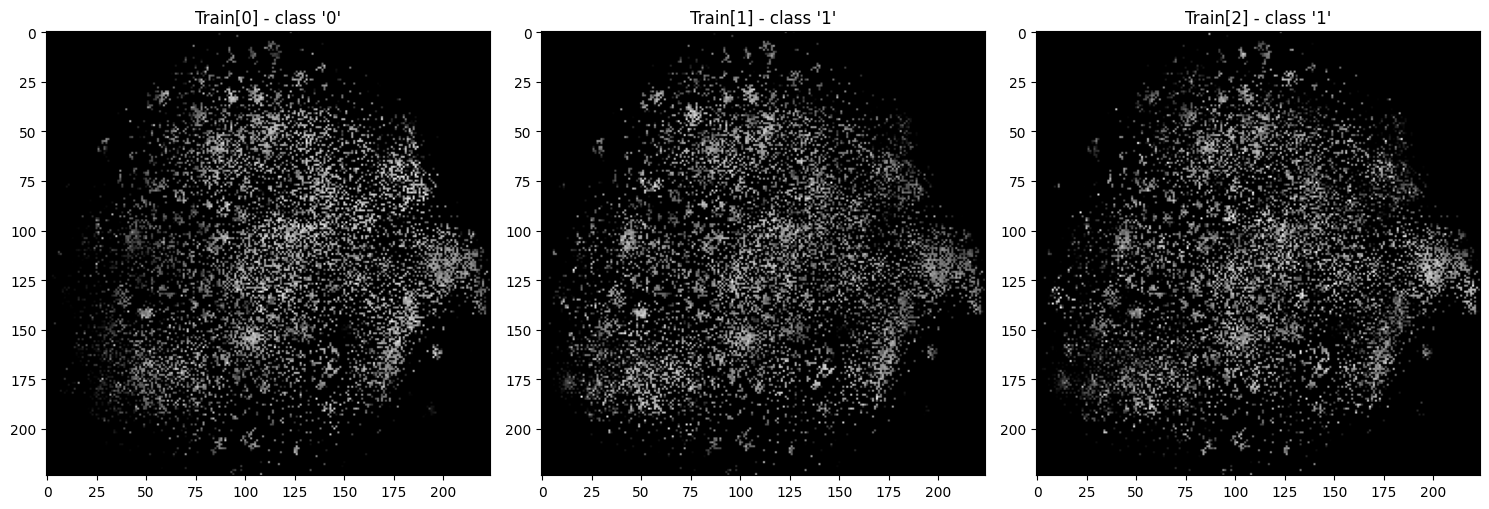

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train_enc[i]}'")
plt.tight_layout()

In [ ]:
start_time = time.time()
# Set random seed for reproducibility
random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=16
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-03,
    momentum=0.9
)

net.train()
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #clear_output(wait=True)
        #display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print epoch statistics
    if not (epoch % 10):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# End timing
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time_2 = end_time - start_time
print(f"Total elapsed time: {elapsed_time_1 + elapsed_time_2} seconds")

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.39918607
[10] loss: 0.00067700
[20] loss: 0.03737474
[30] loss: 0.00053152
[40] loss: 0.00032101
[49] loss: 0.00830905
The test accuracy was 1.000
The F1 score was 1.000
The Precession was 1.000
Total elapsed time: 118.58881378173828 seconds


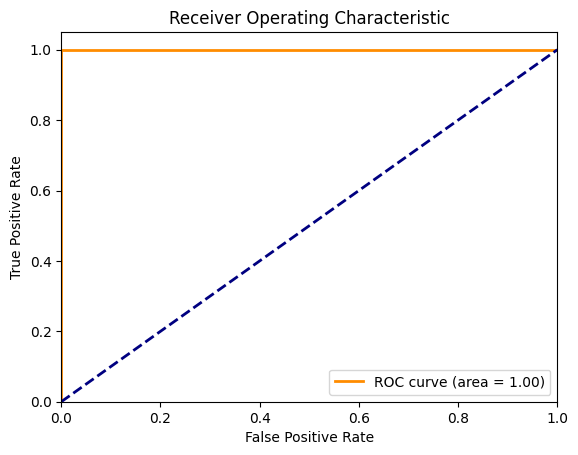

In [ ]:

# Predict probabilities
test_probabilities = np.empty((0, 2))

net.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        test_probabilities = np.vstack([test_probabilities, probabilities])

# Compute probabilities for the positive class
positive_probabilities = test_probabilities[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_true, positive_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Feature selection

In [ ]:
# Start timing
start_time = time.time()
# X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
# X_train, y_train_enc = smote.fit_resample(X, y_enc)
X_train, y_train_enc = X, y_enc

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)[var_filter]

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
# X_test_norm = mms.transform(X_test[:, var_filter])

distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

it.fit(X_train_norm, y=y_train_enc, plot=False)
X_train_img = it.transform(X_train_norm)
# X_test_img = it.transform(X_test_norm)

start_time = time.time()
# Set random seed for reproducibility
random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=16
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
# y_test_tensor = torch.from_numpy(y_test_enc).to(device)
# testset = TensorDataset(X_test_tensor, y_test_tensor)
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
# y_test_tensor = torch.from_numpy(y_test_enc).to(device)
# testset = TensorDataset(X_test_tensor, y_test_tensor)
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-03,
    momentum=0.9
)

net.train()
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #clear_output(wait=True)
        #display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print epoch statistics
    if not (epoch % 10):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

# test_predicted = np.empty(0)
# test_true = np.empty(0)

# net.eval()
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(testloader):
#         pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
#         test_predicted = np.append(test_predicted, pred)
#         test_true = np.append(test_true, labels.cpu().detach().numpy())
# print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
# print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# # End timing
# end_time = time.time()
# # Calculate and print the elapsed time
# elapsed_time_2 = end_time - start_time
# print(f"Total elapsed time: {elapsed_time_1 + elapsed_time_2} seconds")

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.31576940
[10] loss: 0.00084765
[20] loss: 0.00083457
[30] loss: 0.00020588
[40] loss: 0.00029198
[49] loss: 0.00010783


In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=32, flatten_method=fl_method)
aggregated_cam = camfs.calculate_aggregated_activations(X_train_tensor, y_train_tensor, batch_size=32)

In [ ]:
fs_threshold_agg = 0.75
fs_threshold_cls = 0.7
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold_cls)
top_features = camfs.select_top_features(aggregated_cam, top_n=20, threshold=fs_threshold_agg)

In [ ]:
feature_names = retained_features[top_features]
print(feature_names)
len(feature_names)

['8529' '54575' '284573' '642843' '336' '345' '100133171' '266' '60439'
 '6736' '90665' '442862' '401629' '286554' '246126' '84663' '1617' '55410'
 '9087' '83869' '64595' '159119']


22

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = retained_features[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")

  839 features selected for LUAD: 177, 2823, 6247, 285016, 2996, 1512, 5923, 3240, 117156...
  738 features selected for LUSC: 283537, 55365, 768097, 768096, 113675, 8742, 4056, 7351, 5319...


In [ ]:
feat = pd.DataFrame()
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    feat = pd.concat([feat, pd.DataFrame({'cancer':le_mapping[cat], 'gene':feature_names})])
fdf = feat.assign(selected=1).pivot(index='cancer', columns='gene', values="selected").fillna(0).astype(int)

pd.DataFrame(
    np.matmul(fdf.values,fdf.T.values),
    index=fdf.index.values,
    columns=fdf.index.values
)

,LUAD,LUSC
LUAD,839,715
LUSC,715,738


In [ ]:
rows = []
for cat, idx in feat_idx.items():
    feature_names = retained_features[idx]
    row = {"Category": cat, "Features Selected": ", ".join(feature_names)}
    rows.append(row)
df = pd.DataFrame(rows)
df

,Category,Features Selected
0,0,"23630, 177, 2823, 6247, 285016, 2996, 1512, 59..."
1,1,"23704, 283537, 55365, 768097, 768096, 113675, ..."


### Different train split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()

  print(f"The split ratio is: {ratio}:")

  # Start timing
  start_time = time.time()
  X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=38, stratify=y_enc)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
  retained_features = np.array(genes)[var_filter]

  mms = MinMaxScaler()
  X_train_norm = mms.fit_transform(X_train[:, var_filter])
  X_test_norm = mms.transform(X_test[:, var_filter])

  distance_metric = 'cosine'
  reducer = TSNE(
      n_components=2,
      metric=distance_metric,
      init='random',
      learning_rate='auto',
      n_jobs=-1
  )

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  pixel_size = (224,224)
  it = ImageTransformer(
      feature_extractor=reducer,
      pixels=pixel_size)

  it.fit(X_train_norm, y=y_train_enc, plot=False)
  X_train_img = it.transform(X_train_norm)
  X_test_img = it.transform(X_test_norm)

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  # Ensure deterministic behavior in PyTorch
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
  net = net.to(device)

  batch_size=16
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
  ])

  X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
  y_train_tensor = torch.from_numpy(y_train_enc).to(device)
  trainset = TensorDataset(X_train_tensor, y_train_tensor)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
  y_test_tensor = torch.from_numpy(y_test_enc).to(device)
  testset = TensorDataset(X_test_tensor, y_test_tensor)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
      net.parameters(),
      lr=1e-03,
      momentum=0.9
  )

  net.train()
  for epoch in range(50):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(trainloader):
          #clear_output(wait=True)
          #display(f"Epoch {epoch:03d}, batch {i:03d}")
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          # print epoch statistics
      if not (epoch % 10):
          print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
  print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

  test_predicted = np.empty(0)
  test_true = np.empty(0)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
          test_predicted = np.append(test_predicted, pred)
          test_true = np.append(test_true, labels.cpu().detach().numpy())
  print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
  print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
  print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # AUC
  y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

  test_probabilities = np.empty((0, num_classes))
  test_probabilities = np.empty((0, 2))  # Assuming binary classification (2 classes)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          outputs = net(inputs)
          probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
          test_probabilities = np.vstack([test_probabilities, probabilities])

  # Select the probabilities for the positive class (assuming it's the second column)
  positive_class_probabilities = test_probabilities[:, 1]

  # Calculate AUC
  auc_score = roc_auc_score(y_test_enc, positive_class_probabilities)
  print(f"The average AUC is: {auc_score:.3f}")

  avg_acc.append(accuracy_score(test_predicted, test_true))
  avg_f1.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_pre.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is: 0.1:


NameError: name 'X' is not defined

In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Accuracy: 1.0
Average F1 Score: 1.0
Average Precision: 1.0
Average Computing time: 106.37894377708434
Average AUC: 1.0


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
 #[3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=38)
    #X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_test_norm = mms.transform(X_test[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224, 224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train_enc, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_test_img = it.transform(X_test_norm)

    # Set random seed for reproducibility
    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train_enc).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
    y_test_tensor = torch.from_numpy(y_test_enc).to(device)
    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-03,
        momentum=0.9,
        weight_decay=1e-04,
        nesterov=True
    )

    net.train()
    for epoch in range(50):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    test_predicted = np.empty(0)
    test_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            test_predicted = np.append(test_predicted, pred)
            test_true = np.append(test_true, labels.cpu().detach().numpy())
    # print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
    # print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
    # print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    # print(f"Total elapsed time: {elapsed_time} seconds")

    # AUC
    y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

    test_probabilities = np.empty((0, num_classes))
    test_probabilities = np.empty((0, 2))  # Assuming binary classification (2 classes)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = net(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            test_probabilities = np.vstack([test_probabilities, probabilities])

    # Select the probabilities for the positive class (assuming it's the second column)
    positive_class_probabilities = test_probabilities[:, 1]

    # Calculate AUC
    auc_score = roc_auc_score(y_test_enc, positive_class_probabilities)

    avg_acc_s.append(accuracy_score(test_predicted, test_true))
    avg_f1_s.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.35877121
[10] loss: 0.00097807
[20] loss: 0.00045478
[30] loss: 0.00022710
[40] loss: 0.00013568
[49] loss: 0.00020959
Training seed 8:
[0] loss: 0.35364009
[10] loss: 0.00162592
[20] loss: 0.00047701
[30] loss: 0.00110204
[40] loss: 0.00066603
[49] loss: 0.00072278
Training seed 19:
[0] loss: 0.37204127
[10] loss: 0.00072962
[20] loss: 0.00044885
[30] loss: 0.00030527
[40] loss: 0.00015505
[49] loss: 0.00037522
Training seed 66:
[0] loss: 0.31574300
[10] loss: 0.00327051
[20] loss: 0.00025188
[30] loss: 0.00021054
[40] loss: 0.00014363
[49] loss: 0.00011557
Training seed 38:
[0] loss: 0.31948221
[10] loss: 0.00342088
[20] loss: 0.00037827
[30] loss: 0.00025815
[40] loss: 0.00016758
[49] loss: 0.00067033
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 105.01222825050354
The split ratio is: 0.15:
Training seed 3:
[0] loss: 0.31817108
[10] loss: 0.00067382
[20] loss: 0.00024214
[30] loss: 0.00016862
[40] loss: 0.00018357
[49] loss: 

### Examining the performance of DeepInsight by progressively decreasing the ratio.

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
 #[3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=38)
    #X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_test_norm = mms.transform(X_test[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224, 224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train_enc, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_test_img = it.transform(X_test_norm)

    # Set random seed for reproducibility
    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train_enc).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
    y_test_tensor = torch.from_numpy(y_test_enc).to(device)
    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-03,
        momentum=0.9,
        weight_decay=1e-04,
        nesterov=True
    )

    net.train()
    for epoch in range(50):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    test_predicted = np.empty(0)
    test_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            test_predicted = np.append(test_predicted, pred)
            test_true = np.append(test_true, labels.cpu().detach().numpy())
    # print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
    # print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
    # print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    # print(f"Total elapsed time: {elapsed_time} seconds")

    # AUC
    y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

    test_probabilities = np.empty((0, num_classes))
    test_probabilities = np.empty((0, 2))  # Assuming binary classification (2 classes)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = net(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            test_probabilities = np.vstack([test_probabilities, probabilities])

    # Select the probabilities for the positive class (assuming it's the second column)
    positive_class_probabilities = test_probabilities[:, 1]

    # Calculate AUC
    auc_score = roc_auc_score(y_test_enc, positive_class_probabilities)

    avg_acc_s.append(accuracy_score(test_predicted, test_true))
    avg_f1_s.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
[0] loss: 0.35858387
[10] loss: 0.00096782
[20] loss: 0.00051158
[30] loss: 0.00025116
[40] loss: 0.00013113
[49] loss: 0.00015987
Training seed 8:
[0] loss: 0.35096087
[10] loss: 0.00198248
[20] loss: 0.00048707
[30] loss: 0.00312108
[40] loss: 0.00046761
[49] loss: 0.00059247
Training seed 19:
[0] loss: 0.35774528
[10] loss: 0.00083065
[20] loss: 0.00044037
[30] loss: 0.00028096
[40] loss: 0.00015866
[49] loss: 0.00653158
Training seed 66:
[0] loss: 0.32576225
[10] loss: 0.00216713
[20] loss: 0.00023873
[30] loss: 0.00038825
[40] loss: 0.00016415
[49] loss: 0.00011339
Training seed 38:
[0] loss: 0.31624928
[10] loss: 0.00202555
[20] loss: 0.00037396
[30] loss: 0.00022276
[40] loss: 0.00020895
[49] loss: 0.00143942
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 100.63940148353576
The split ratio is: 0.2:
Training seed 3:
[0] loss: 0.37985775
[10] loss: 0.00142037
[20] loss: 0.00077066
[30] loss: 0.0

### Different resolutions


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

image_resolution = [50, 120, 180, 224, 250, 280, 320, 400]
for res in image_resolution:
  # Start timing
  start_time = time.time()

  print(f"The Resolution is: {res}:")

  # Start timing
  start_time = time.time()
  X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
  retained_features = np.array(genes)[var_filter]

  mms = MinMaxScaler()
  X_train_norm = mms.fit_transform(X_train[:, var_filter])
  X_test_norm = mms.transform(X_test[:, var_filter])

  distance_metric = 'cosine'
  reducer = TSNE(
      n_components=2,
      metric=distance_metric,
      init='random',
      learning_rate='auto',
      n_jobs=-1
  )

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  pixel_size = (res,res)
  it = ImageTransformer(
      feature_extractor=reducer,
      pixels=pixel_size)

  it.fit(X_train_norm, y=y_train_enc, plot=False)
  X_train_img = it.transform(X_train_norm)
  X_test_img = it.transform(X_test_norm)

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  # Ensure deterministic behavior in PyTorch
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
  net = net.to(device)

  batch_size=16
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
  ])

  X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
  y_train_tensor = torch.from_numpy(y_train_enc).to(device)
  trainset = TensorDataset(X_train_tensor, y_train_tensor)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
  y_test_tensor = torch.from_numpy(y_test_enc).to(device)
  testset = TensorDataset(X_test_tensor, y_test_tensor)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
      net.parameters(),
      lr=1e-03,
      momentum=0.9
  )

  net.train()
  for epoch in range(50):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(trainloader):
          #clear_output(wait=True)
          #display(f"Epoch {epoch:03d}, batch {i:03d}")
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          # print epoch statistics
      if not (epoch % 10):
          print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
  print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

  test_predicted = np.empty(0)
  test_true = np.empty(0)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
          test_predicted = np.append(test_predicted, pred)
          test_true = np.append(test_true, labels.cpu().detach().numpy())
  print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
  print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
  print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # AUC
  y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

  test_probabilities = np.empty((0, num_classes))
  test_probabilities = np.empty((0, 2))  # Assuming binary classification (2 classes)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          outputs = net(inputs)
          probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
          test_probabilities = np.vstack([test_probabilities, probabilities])

  # Select the probabilities for the positive class (assuming it's the second column)
  positive_class_probabilities = test_probabilities[:, 1]

  # Calculate AUC
  auc_score = roc_auc_score(y_test_enc, positive_class_probabilities)
  print(f"The average AUC is: {auc_score:.3f}")

  avg_acc.append(accuracy_score(test_predicted, test_true))
  avg_f1.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_pre.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The Resolution is: 50:


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.32881229
[10] loss: 0.00106011
[20] loss: 0.00119305
[30] loss: 0.00021319
[40] loss: 0.00023667
[49] loss: 0.00085046
The test accuracy was 0.990
The F1 score was 0.990
The Precession was 0.990
Total elapsed time: 95.0605902671814 seconds
The average AUC is: 1.000
The Resolution is: 120:
[0] loss: 0.31321383
[10] loss: 0.00361890
[20] loss: 0.02899486
[30] loss: 0.00121241
[40] loss: 0.00212254
[49] loss: 0.00542914
The test accuracy was 1.000
The F1 score was 1.000
The Precession was 1.000
Total elapsed time: 81.60883021354675 seconds
The average AUC is: 1.000
The Resolution is: 180:
[0] loss: 0.34669764
[10] loss: 0.00130880
[20] loss: 0.00048495
[30] loss: 0.00019344
[40] loss: 0.00018605
[49] loss: 0.00080722
The test accuracy was 0.995
The F1 score was 0.995
The Precession was 0.995
Total elapsed time: 90.95440578460693 seconds
The average AUC is: 1.000
The Resolution is: 224:
[0] loss: 0.39918607
[10] loss: 0.00067700
[20] loss: 0.03737474
[30] loss: 0.00053152
[40] 

## NNs

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

lung_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'LUAD', 1: 'LUSC'}


In [ ]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [ ]:
# Define the DCNNs' layers
def build_model(num_classes):
    model = Sequential([
          Dense(2500 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(1000 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(500 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(250 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(125 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(60 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(5 , activation= 'softmax')
    ])
    return model

### Cross validation

In [ ]:
random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

acc_per_fold = []
loss_per_fold = []
fold_no = 1
batch_size = 16
epoch_num = 100

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=38, stratify=y)

num_classes = len(np.unique(y))

for train_index, test_index in kf.split(X_train_temp):

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    print(f'Training for fold {fold_no} ...')

    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])

    history = model.fit(X_train, y_train,
                        epochs=epoch_num,
                        batch_size=batch_size,
                        validation_split = 0.1,
                        callbacks=[early_stopping],
                        verbose = 0)

    y_pred = model.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Calculate metrics
    print(f"Accuracy: {accuracy_score(y_val, y_pred_class)}")
    accuracies.append(accuracy_score(y_val, y_pred_class))
    f1_scores.append(f1_score(y_val, y_pred_class, average='weighted', zero_division=0))
    precisions.append(precision_score(y_val, y_pred_class, average='weighted', zero_division=0))
    recalls.append(recall_score(y_val, y_pred_class, average='weighted', zero_division=0))

    fold_no = fold_no + 1

Training for fold 1 ...


KeyboardInterrupt: 

In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.9804878048780488
Average F1 Score: 0.9804670199325267
Average Precision: 0.9808550846121907
Average Recall: 0.9804878048780488


### Test accuracy

In [ ]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify=y)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])
X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 1)

y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
end_time = time.time()
Eplapse_time = end_time - start_time
print(f"The elapse time is:{Eplapse_time} seconds")

Epoch 1/100
44/44 [==============================] - 4s 18ms/step - loss: 12.5788 - accuracy: 0.5620 - val_loss: 0.4566 - val_accuracy: 0.9744
Epoch 2/100
44/44 [==============================] - 0s 8ms/step - loss: 7.3641 - accuracy: 0.8199 - val_loss: 1.5242 - val_accuracy: 0.9744
Epoch 3/100
44/44 [==============================] - 0s 9ms/step - loss: 5.2945 - accuracy: 0.9107 - val_loss: 0.3376 - val_accuracy: 0.9872
Epoch 4/100
44/44 [==============================] - 0s 10ms/step - loss: 1.4998 - accuracy: 0.9568 - val_loss: 0.3039 - val_accuracy: 0.9744
Epoch 5/100
44/44 [==============================] - 0s 9ms/step - loss: 1.8333 - accuracy: 0.9597 - val_loss: 0.1292 - val_accuracy: 0.9744
Epoch 6/100
44/44 [==============================] - 0s 8ms/step - loss: 1.2372 - accuracy: 0.9683 - val_loss: 0.4444 - val_accuracy: 0.9744
Epoch 7/100
44/44 [==============================] - 0s 9ms/step - loss: 1.3013 - accuracy: 0.9741 - val_loss: 0.0974 - val_accuracy: 0.9872
Epoch 8/10

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate recall
recall = recall_score(y_test, y_pred_class, average='weighted')
print(f'Recall: {recall * 100:.2f}%')

# Calculate precision
precision = precision_score(y_test, y_pred_class, average='weighted')
print(f'Precision: {precision * 100:.2f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred_class, average='weighted')
print(f'F1 Score: {f1 * 100:.2f}%')

report = classification_report(y_test,
                               y_pred_class,
                               target_names=['0', '1'])
print(report)

Accuracy: 98.45%
Recall: 98.45%
Precision: 98.50%
F1 Score: 98.45%
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       101
           1       1.00      0.97      0.98        93

    accuracy                           0.98       194
   macro avg       0.99      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



7/7 [==============================] - 0s 3ms/step


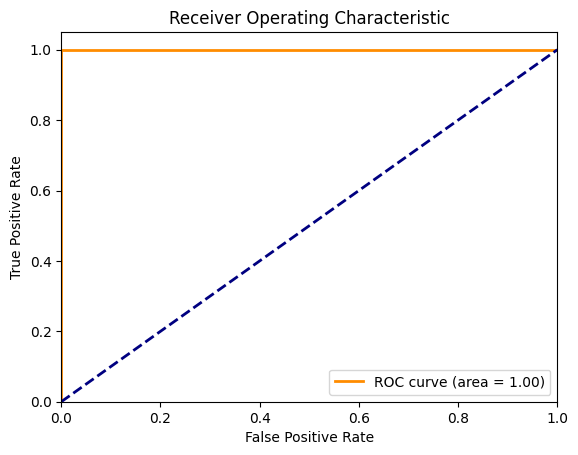

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predict probability scores
y_prob = model.predict(X_test)

# If it's binary classification, extract probabilities for the positive class
if num_classes == 2:
    positive_probabilities = y_prob[:, 1]
else:
    raise ValueError("The provided code snippet is for binary classification. Adjust for multi-class if needed.")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, positive_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Feature selection

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify=y)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])
X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 0)

In [ ]:
import tensorflow as tf

def integrated_gradients(model, baseline, inputs, steps=50):
    # Generate the interpolated inputs between baseline and input
    interpolated_inputs = [baseline + (step / steps) * (inputs - baseline) for step in range(steps + 1)]
    interpolated_inputs = tf.convert_to_tensor(interpolated_inputs)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Set a baseline (can be a zero vector)
baseline = np.zeros(X_train.shape[1])

# Compute Integrated Gradients for a sample
ig = integrated_gradients(model, baseline, X_test[:100])
ig_sum = tf.reduce_mean(ig, axis=0)
top_20_indices = np.argsort(ig_sum)[-20:]
top_20_genes = retained_features[top_20_indices]


In [ ]:
print(top_20_genes)

['5939' '100132724' '735301' '342357' '619505' '4985' '100130988' '23063'
 '94015' '84673' '401994' '375337' '643394' '338755' '57348' '57580'
 '392309' '4988' '619562' '6941']


### Different train test ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is: {ratio}:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=38, stratify=y)

  model = build_model(num_classes)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Define the early stopping callback
  early_stopping = EarlyStopping(
      monitor='val_loss',  # Monitor the validation loss
      patience=20,         # Number of epochs with no improvement after which training will be stopped
      restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
  )

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])
  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])

  history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

  y_pred = model.predict(X_test)
  y_pred_class = np.argmax(y_pred, axis=1)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred_class)
  print(f'Accuracy: {accuracy * 100:.2f}%')

  # Calculate recall
  recall = recall_score(y_test, y_pred_class, average='weighted')
  print(f'Recall: {recall * 100:.2f}%')

  # Calculate precision
  precision = precision_score(y_test, y_pred_class, average='weighted')
  print(f'Precision: {precision * 100:.2f}%')

  # Calculate F1 score
  f1 = f1_score(y_test, y_pred_class, average='weighted')
  print(f'F1 Score: {f1 * 100:.2f}%')

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")


  auc_score = roc_auc_score(y_test, y_pred_class)
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy)
  avg_f1.append(f1)
  avg_pre.append(precision)
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is: 0.1:
4/4 [==============================] - 0s 3ms/step
Accuracy: 98.97%
Recall: 98.97%
Precision: 98.99%
F1 Score: 98.97%
Total elapsed time: 13.29064130783081 seconds
AUC for split ratio 0.1: 0.99
The split ratio is: 0.15:
5/5 [==============================] - 0s 3ms/step
Accuracy: 96.55%
Recall: 96.55%
Precision: 96.56%
F1 Score: 96.55%
Total elapsed time: 12.516761064529419 seconds
AUC for split ratio 0.15: 0.9652380952380953
The split ratio is: 0.2:
7/7 [==============================] - 0s 3ms/step
Accuracy: 98.45%
Recall: 98.45%
Precision: 98.46%
F1 Score: 98.45%
Total elapsed time: 13.131007194519043 seconds
AUC for split ratio 0.2: 0.984296816778452
The split ratio is: 0.25:
8/8 [==============================] - 0s 3ms/step
Accuracy: 95.45%
Recall: 95.45%
Precision: 95.70%
F1 Score: 95.44%
Total elapsed time: 11.60076117515564 seconds
AUC for split ratio 0.25: 0.952928297755884
The split ratio is: 0.3:
10/10 [==============================] - 0s 2ms/step


In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Accuracy: 0.973340658630385
Average F1 Score: 0.973309834221938
Average Precision: 0.9739034105812296
Average Computing time: 12.141603899002074
Average AUC: 0.9729087646854406


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_class)

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
4/4 [==============================] - 0s 17ms/step
Training seed 8:
4/4 [==============================] - 0s 3ms/step
Training seed 19:
4/4 [==============================] - 0s 3ms/step
Training seed 66:
4/4 [==============================] - 0s 3ms/step
Training seed 38:
4/4 [==============================] - 0s 3ms/step
Avreage accuracy: 0.9855670103092784
Avreage F1: 0.9855617378632286
Avreage precision: 0.9857660431341451
Avreage auc: 0.9853617021276595
Avreage time: 14.587902212142945
The split ratio is: 0.15:
Training seed 3:
5/5 [==============================] - 0s 3ms/step
Training seed 8:
5/5 [==============================] - 0s 3ms/step
Training seed 19:
5/5 [==============================] - 0s 3ms/step
Training seed 66:
5/5 [==============================] - 0s 3ms/step
Training seed 38:
5/5 [==============================] - 0s 3ms/step
Avreage accuracy: 0.9820689655172414
Avreage F1: 0.9820328118823876
Avreage precision: 0.98

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_class)

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3:
10/10 [==============================] - 0s 2ms/step
Training seed 8:
10/10 [==============================] - 0s 2ms/step
Training seed 19:
10/10 [==============================] - 0s 2ms/step
Training seed 66:
10/10 [==============================] - 0s 2ms/step
Training seed 38:
10/10 [==============================] - 0s 2ms/step
Avreage accuracy: 0.9786206896551726
Avreage F1: 0.9785966375101737
Avreage precision: 0.979745767633722
Avreage auc: 0.9782695697746439
Avreage time: 13.381613397598267
The split ratio is: 0.4:
Training seed 3:
13/13 [==============================] - 0s 2ms/step
Training seed 8:
13/13 [==============================] - 0s 2ms/step
Training seed 19:
13/13 [==============================] - 0s 2ms/step
Training seed 66:
13/13 [==============================] - 0s 2ms/step
Training seed 38:
13/13 [==============================] - 0s 2ms/step
Avreage accuracy: 0.9881136950904393
Avreage F1: 0.9881111321228812
Avreag

## LightGBM

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

lung_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'LUAD', 1: 'LUSC'}


In [ ]:
import lightgbm as lgb
# tell LightGBM to use the NVIDIA OpenCL installable client driver (ICD)
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Cross validation

In [ ]:
random_state = 38
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
accuracies_gbm = []
f1_scores_gbm = []
precisions_gbm = []
recalls_gbm = []
confusion_matrices_gbm = []
kappas_gbm = []
hamming_distances_gbm = []

for train_index, test_index in kf.split(X_train_temp):
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])


    train_data = lgb.Dataset(X_train, label=y_train)

    # Define the parameters for LightGBM
    params = {
        'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': random_state
    }
    # Train the model
    num_round = 10
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_val)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics
    accuracies_gbm.append(accuracy_score(y_val, y_pred_class))
    f1_scores_gbm.append(f1_score(y_val, y_pred_class, average='weighted'))
    precisions_gbm.append(precision_score(y_val, y_pred_class, average='weighted'))
    recalls_gbm.append(recall_score(y_val, y_pred_class, average='weighted'))

In [ ]:
print(f'Average Accuracy: {np.mean(accuracies_gbm)}')
print(f'Average F1 Score: {np.mean(f1_scores_gbm)}')
print(f'Average Precision: {np.mean(precisions_gbm)}')
print(f'Average Recall: {np.mean(recalls_gbm)}')

Average Accuracy: 0.9939024390243901
Average F1 Score: 0.993903709430573
Average Precision: 0.9941096445257502
Average Recall: 0.9939024390243901


### Test accuracy

In [ ]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify = y)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])

X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])


train_data = lgb.Dataset(X_train, label=y_train)

# Define the parameters for LightGBM
params = {
    #'device_type': 'gpu',
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 38
}
# Train the model
num_round = 10
lgbm_model = lgb.train(params, train_data, num_round)
# Predict on the test set
y_pred = lgbm_model.predict(X_test)
# Convert the probabilities into class predictions
y_pred_class = np.argmax(y_pred, axis=1)
# Calculate metrics

print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
print(f"Precision: {precison_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

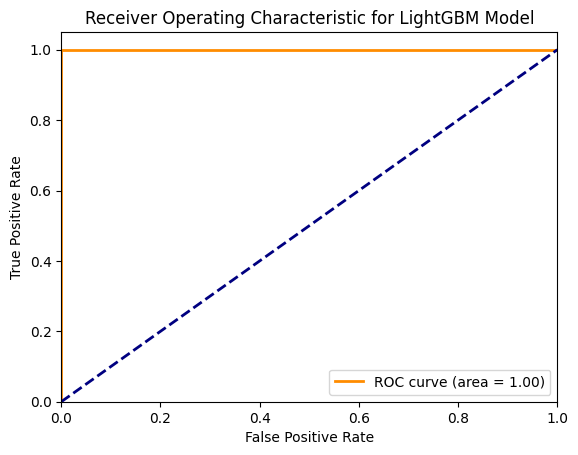

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# LightGBM gives probability for the positive class in binary classification
positive_probabilities = y_pred[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, positive_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LightGBM Model')
plt.legend(loc="lower right")
plt.show()


### Feature selection

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify = y)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# # Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])


train_data = lgb.Dataset(X, label=y)

# Define the parameters for LightGBM
params = {
    #'device_type': 'gpu',
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 38
}
# Train the model
num_round = 5
lgbm_model = lgb.train(params, train_data, num_round)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
retained_features = np.array(genes)
# Get feature importances from the LightGBM model
importances = lgbm_model.feature_importance(importance_type='split')

# Sort the feature indices based on importance
sorted_indices = np.argsort(importances)[::-1]

# Select the top 20 features
top_20_indices = sorted_indices[:21]

# Retrieve the gene names for the top 20 features
top_20_genes = retained_features[top_20_indices]

print(top_20_genes)

['100133144' '729884' '100134869' '16' '21' '390110' '53947' '3728'
 '169611' '10816' '55227' '390439' '64431' '408187' '9530' '5493' '5825'
 '2625' '146' '553137' '391714']


### Different train test ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is {ratio}:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=38, stratify = y)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])

  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])


  train_data = lgb.Dataset(X_train, label=y_train)

  # Define the parameters for LightGBM
  params = {
      #'device_type': 'gpu',
      'objective': 'multiclass',
      'num_class': len(np.unique(y)),
      'metric': 'multi_logloss',
      'is_unbalance': 'true',
      'boosting_type': 'gbdt',
      'num_leaves': 50,
      'learning_rate': 0.05,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'verbose': 0,
      'random_state': 38
  }
  # Train the model
  num_round = 10
  lgbm_model = lgb.train(params, train_data, num_round)
  # Predict on the test set
  y_pred = lgbm_model.predict(X_test)
  # Convert the probabilities into class predictions
  y_pred_class = np.argmax(y_pred, axis=1)
  # Calculate metrics

  print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
  print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test, y_pred_class)
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy_score(y_pred_class, y_test))
  avg_f1.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is 0.1:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [ ]:
# Print the average metrics
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Computing time: 5.789310312271118
Average Accuracy: 1.0
Average F1 Score: 1.0
Average Precision: 1.0
Average AUC: 1.0


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = lgb.Dataset(X_train, label=y_train)
    # Define the parameters for LightGBM
    params = {
        #'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 38
    }
    # Train the model
    num_round = 5
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics

    #print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
    #print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time_1} seconds")

    auc_score = roc_auc_score(y_test, y_pred_class)


    avg_acc_s.append(accuracy_score(y_pred_class, y_test))
    avg_f1_s.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))


The split ratio is: 0.1:
Training seed 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training seed 8:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = lgb.Dataset(X_train, label=y_train)
    # Define the parameters for LightGBM
    params = {
        #'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 38
    }
    # Train the model
    num_round = 5
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics

    #print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
    #print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time_1} seconds")

    auc_score = roc_auc_score(y_test, y_pred_class)


    avg_acc_s.append(accuracy_score(y_pred_class, y_test))
    avg_f1_s.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))


The split ratio is: 0.3:
Training seed 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training seed 8:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

## Decision Tree

### Cross validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

lung_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )

{0: 'LUAD', 1: 'LUSC'}


In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=38, stratify=y_enc)
print(X_train_temp.shape)
print(X_test.shape)

random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []


for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])

    clf= DecisionTreeClassifier(random_state = 38)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_val)

     # Calculate metrics
    print(f"Accuracy: {accuracy_score(y_pred, y_val) * 100 :.3f}")
    accuracies.append(accuracy_score(y_pred, y_val))
    f1_scores.append(f1_score(y_pred, y_val, average='weighted', zero_division=0))
    precisions.append(precision_score(y_pred, y_val, average='weighted', zero_division=0))
    recalls.append(recall_score(y_pred, y_val, average='weighted', zero_division=0))

    fold_no += 1

(821, 19218)
(145, 19218)
Training for fold1...
Accuracy: 100.000
Training for fold2...
Accuracy: 100.000
Training for fold3...
Accuracy: 100.000
Training for fold4...
Accuracy: 100.000
Training for fold5...
Accuracy: 100.000
Training for fold6...
Accuracy: 97.561
Training for fold7...
Accuracy: 100.000
Training for fold8...
Accuracy: 100.000
Training for fold9...
Accuracy: 100.000
Training for fold10...
Accuracy: 98.780


In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.9963414634146343
Average F1 Score: 0.9963452824289563
Average Precision: 0.996494684177611
Average Recall: 0.9963414634146343


### Test accuracy

In [ ]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=38, stratify=y_enc)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])

X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])

clf= DecisionTreeClassifier(random_state = 38)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

  # Calculate metrics
print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Elapsed time: 1.8105907440185547 seconds


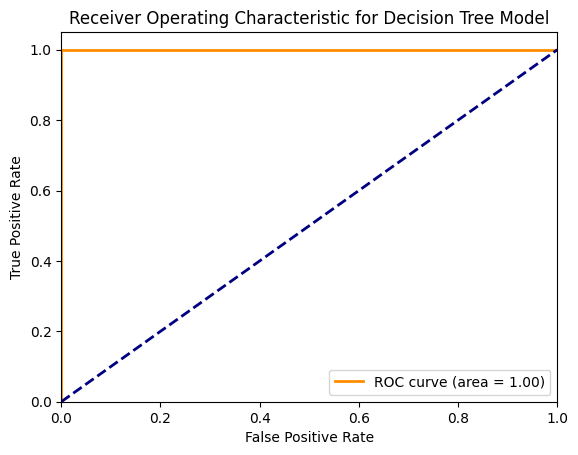

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predict probability scores
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree Model')
plt.legend(loc="lower right")
plt.show()


### Feature selection

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=38, stratify=y_enc)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# # Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])
retained_features = np.array(genes)

clf= DecisionTreeClassifier(random_state = 38,
                            criterion = 'gini',
                            max_depth =  20,
                            max_features = 'sqrt',
                            min_samples_leaf = 2,
                            min_samples_split = 2)
clf.fit(X,y)

DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       random_state=38)

In [ ]:
# Get feature importances from the decision tree model
importances = clf.feature_importances_

# Sort the importances and get the indices of the top 20
top_20_indices = np.argsort(importances)[-20:]

# Map these indices to the corresponding gene names in retained_features
top_20_genes = retained_features[top_20_indices]

top_20_genes


array(['2299', '121643', '1112', '3344', '8456', '2305', '668', '8928',
       '2300', '221937', '22887', '55810', '2302', '344167', '399823',
       '3607', '26009', '340745', '282966', '378951'], dtype=object)

### Different train split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is {ratio}:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=38, stratify=y_enc)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])

  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])

  clf= DecisionTreeClassifier(random_state = 38)
  clf.fit(X_train,y_train)
  y_pred= clf.predict(X_test)

    # Calculate metrics
  print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
  print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test, y_pred)
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy_score(y_pred, y_test))
  avg_f1.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is 0.1:
Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 1.864405632019043 seconds
AUC for split ratio 0.1: 1.0
The split ratio is 0.15:
Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 1.7638144493103027 seconds
AUC for split ratio 0.15: 1.0
The split ratio is 0.2:
Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 1.6884312629699707 seconds
AUC for split ratio 0.2: 1.0
The split ratio is 0.25:
Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 1.6140520572662354 seconds
AUC for split ratio 0.25: 1.0
The split ratio is 0.3:
Accuracy: 100.000
F1 Score: 1.0
Precision: 1.0
Total elapsed time: 1.4908995628356934 seconds
AUC for split ratio 0.3: 1.0


In [ ]:
# Print the average metrics
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Computing time: 1.684320592880249
Average Accuracy: 1.0
Average F1 Score: 1.0
Average Precision: 1.0
Average AUC: 1.0


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf= DecisionTreeClassifier(random_state = 38)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_test)

    # Calculate metrics
    # print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
    # print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
    # print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time} seconds")

    # Get the probability estimates
    y_pred_proba = clf.predict_proba(X_test)


    auc_score = roc_auc_score(y_test, y_pred)

    avg_acc_s.append(accuracy_score(y_pred, y_test))
    avg_f1_s.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
Total elapsed time: 2.5765931606292725 seconds
Training seed 8:
Total elapsed time: 2.569857358932495 seconds
Training seed 19:
Total elapsed time: 2.549605131149292 seconds
Training seed 66:
Total elapsed time: 2.540884494781494 seconds
Training seed 38:
Total elapsed time: 2.5360426902770996 seconds
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 2.5545965671539306
The split ratio is: 0.15:
Training seed 3:
Total elapsed time: 2.4102768898010254 seconds
Training seed 8:
Total elapsed time: 2.417027235031128 seconds
Training seed 19:
Total elapsed time: 2.405172348022461 seconds
Training seed 66:
Total elapsed time: 2.425058603286743 seconds
Training seed 38:
Total elapsed time: 2.4070653915405273 seconds
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 2.412920093536377
The split ratio is: 0.2:
Training seed 3:
Total elapsed time: 2.274869203567505 seconds


### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    #X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf= DecisionTreeClassifier(random_state = 38)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_test)

    # Calculate metrics
    # print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
    # print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
    # print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time} seconds")

    # Get the probability estimates
    y_pred_proba = clf.predict_proba(X_test)


    auc_score = roc_auc_score(y_test, y_pred)

    avg_acc_s.append(accuracy_score(y_pred, y_test))
    avg_f1_s.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3:
Total elapsed time: 1.9860758781433105 seconds
Training seed 8:
Total elapsed time: 2.0031020641326904 seconds
Training seed 19:
Total elapsed time: 2.0020132064819336 seconds
Training seed 66:
Total elapsed time: 1.9866228103637695 seconds
Training seed 38:
Total elapsed time: 1.9886529445648193 seconds
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 1.9932933807373048
The split ratio is: 0.4:
Training seed 3:
Total elapsed time: 1.7242765426635742 seconds
Training seed 8:
Total elapsed time: 1.73915433883667 seconds
Training seed 19:
Total elapsed time: 1.7402286529541016 seconds
Training seed 66:
Total elapsed time: 1.7428069114685059 seconds
Training seed 38:
Total elapsed time: 1.7375080585479736 seconds
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 1.736794900894165
The split ratio is: 0.5:
Training seed 3:
Total elapsed time: 1.4889187812805176 seco

## DCGN

In [ ]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1)
y = lung_cancer_no_na['Subtype']

lung_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'LUAD', 1: 'LUSC'}


In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Bidirectional, GRU, Flatten, Dropout

In [ ]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [ ]:
def build_model(num_classes):
    model = Sequential([
    Dense(1024,
          activation=gelu,
          kernel_regularizer=regularizers.l2()),

    Reshape((32, 32, 1)),

    Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Reshape((128, 64)),

    Bidirectional(
        GRU(64, return_sequences=True,
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))
    ),

    Reshape((128, 128, 1)),

    Conv2D(filters=64, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(128, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dense(64, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.6),
    Dense(32, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.7),

    Dense(5, activation= 'softmax')
    ])
    return model

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_class)

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Training seed 8:


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Training seed 19:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Training seed 66:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Training seed 38:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Avreage accuracy: 1.0
Avreage F1: 1.0
Avreage precision: 1.0
Avreage auc: 1.0
Avreage time: 67.05837244987488
The split ratio is: 0.15:
Training seed 3:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Training seed 8:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Training seed 19:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Training seed 66:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Training seed 38:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Avreage accuracy: 0.9944827586206897
Avreage F1: 0.9944807857540446
Avreage precision: 0.994591986832727
Avreage auc: 0.9943809523809524
Avreage time: 67.28881125450134
The split ratio is: 0.2:
Training seed 3:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Training seed 8:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Training seed 19:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Training seed 66:
7/

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=3, random_state=38)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test, y_pred_class)

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Training seed 8:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Training seed 19:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Training seed 66:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Training seed 38:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Avreage accuracy: 0.9937931034482759
Avreage F1: 0.9937885865611825
Avreage precision: 0.9939488557419592
Avreage auc: 0.9935823526609177
Avreage time: 66.3032205581665
The split ratio is: 0.4:
Training seed 3:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 8:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 19:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 66:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Training seed 38:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Avreage accuracy: 0.9937984496124033
Avreage F1: 0.9937977293985115
Avreage precision: 0.9938765086601423
Avreage auc: 0.993708874979939
Avreage time: 55.00475010871887
The split ratio is: 0.5:
Training se

### Feature selection

In [8]:
lung_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Lung_cancer_data/Lung_cancer_subtype_data_zscore_normal_withGeneID.csv')

lung_cancer_no_na = lung_cancer.dropna(subset = ['Subtype'])

lung_cancer_no_na = lung_cancer_no_na.dropna(axis = 1)
lung_cancer_no_na.shape

X = lung_cancer_no_na.drop(['Subtype'], axis=1).values
y = lung_cancer_no_na['Subtype'].values
genes = lung_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(lung_cancer_no_na.shape)

{0: 'LUAD', 1: 'LUSC'}
(966, 19219)


In [5]:
retained_features = np.array(genes)

In [1]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Bidirectional, GRU, Flatten, Dropout

In [7]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def build_model(num_classes):
    model = Sequential([
    Dense(1024,
          activation=gelu,
          kernel_regularizer=regularizers.l2()),

    Reshape((32, 32, 1)),

    Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Reshape((128, 64)),

    Bidirectional(
        GRU(64, return_sequences=True,
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))
    ),

    Reshape((128, 128, 1)),

    Conv2D(filters=64, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(128, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dense(64, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.6),
    Dense(32, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.7),

    Dense(5, activation= 'softmax')
    ])
    return model

In [9]:
batch_size = 16
epoch_num = 100

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify=y)

# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=4, random_state=38)
# X_train, y_train = smote.fit_resample(X_train, y_train)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X)
X_train = scaler.transform(X)

history = model.fit(X, y,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 1)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4980 - loss: 9.7178 - val_accuracy: 0.9485 - val_loss: 1.6474
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8969 - loss: 1.5957 - val_accuracy: 1.0000 - val_loss: 0.9137
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9715 - loss: 0.9597 - val_accuracy: 1.0000 - val_loss: 0.8259
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9560 - loss: 1.2809 - val_accuracy: 0.9897 - val_loss: 1.5290
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9760 - loss: 1.1238 - val_accuracy: 1.0000 - val_loss: 1.4620
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9745 - loss: 1.8478 - val_accuracy: 0.9897 - val_loss: 0.5940
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9928 - loss: 0.5413 - val_accuracy: 1.0000 - val_loss: 0.3812
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9966 - loss: 0.3927 - val_accuracy: 1

In [10]:
import tensorflow as tf
import numpy as np

def integrated_gradients(model, baseline, inputs, steps=50):
    # Ensure inputs are correctly shaped (batch_size, num_features)
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    # Generate the interpolated inputs between baseline and input
    interpolated_inputs = [(baseline + (step / steps) * (inputs - baseline)) for step in range(steps + 1)]

    # Stack interpolated inputs along the batch dimension
    interpolated_inputs = tf.stack(interpolated_inputs)

    # Reshape to have (steps+1, batch_size, num_features) instead of (steps+1, batch_size, batch_size, num_features)
    interpolated_inputs = tf.reshape(interpolated_inputs, ((steps + 1) * inputs.shape[0], inputs.shape[1]))

    # Record the gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)

    # Reshape gradients back to (steps+1, batch_size, num_features)
    gradients = tf.reshape(gradients, (steps + 1, inputs.shape[0], inputs.shape[1]))

    # Average the gradients across all steps
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    # Multiply by the input difference to get integrated gradients
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Step 2: Define a baseline (a zero vector, representing absence of any feature)
baseline = np.zeros(X_train.shape[1])

# Step 3: Compute Integrated Gradients for a subset of samples
with tf.device('/CPU:0'):
    ig = integrated_gradients(model, baseline, X_train[:100], steps=10)

# Step 4: Aggregate the Integrated Gradients across samples and identify top features
ig_sum = tf.reduce_mean(ig, axis=0)

# Step 5: Get indices of the top 20 features with highest importance scores
top_20_indices = np.argsort(ig_sum)[-20:]

# Step 6: Extract the feature names from retained features
top_20_features = retained_features[top_20_indices]

# Step 7: Output the top 20 important features
print("Top 20 features:", top_20_features)


Top 20 features: ['4988' '3018' '441911' '85285' '619562' '164714' '7299' '114026' '157310'
 '150921' '677842' '26689' '7455' '677835' '402117' '646625' '390999'
 '390439' '378807' '440956']
